# Image translation (Virtual Staining)

Written by Eduardo Hirata-Miyasaki, Ziwen Liu, and Shalin Mehta, CZ Biohub San Francisco

## Overview

In this exercise, we will _virtually stain_ the nuclei and plasma membrane from the quantitative phase image (QPI), i.e., translate QPI images into fluoresence images of nuclei and plasma membranes.
QPI encodes multiple cellular structures and virtual staining decomposes these structures. After the model is trained, one only needs to acquire label-free QPI data.
This strategy solves the problem as "multi-spectral imaging", but is more compatible with live cell imaging and high-throughput screening.
Virtual staining is often a step towards multiple downstream analyses: segmentation, tracking, and cell state phenotyping.

In this exercise, you will:
- Train a model to predict the fluorescence images of nuclei and plasma membranes from QPI images
- Make it robust to variations in imaging conditions using data augmentions
- Segment the cells
- Use regression and segmentation metrics to evalute the models
- Visualize the image transform learned by the model
- Understand the failure modes of the trained model

[![HEK293T](https://raw.githubusercontent.com/mehta-lab/VisCy/main/docs/figures/svideo_1.png)](https://github.com/mehta-lab/VisCy/assets/67518483/d53a81eb-eb37-44f3-b522-8bd7bddc7755)
(Click on image to play video)


### Goals

#### Part 1: Train a virtual staining model

  - Explore OME-Zarr using [iohub](https://czbiohub-sf.github.io/iohub/main/index.html)
  and the high-content-screen (HCS) format.
  - Use our `viscy.data.HCSDataloader()` dataloader and explore the  3 channel (phase, fluoresecence nuclei and cell membrane)
  A549 cell dataset.
  - Implement data augmentations [MONAI](https://monai.io/) to train a robust model to imaging parameters and conditions.
  - Use tensorboard to log the augmentations, training and validation losses and batches
  - Start the training of the UNeXt2 model to predict nuclei and membrane from phase images.

#### Part 2:Evaluate the model to translate phase into fluorescence.
  - Compare the performance of your trained model with the _VSCyto2D_ pre-trained model.
  - Evaluate the model using pixel-level and instance-level metrics.

#### Part 3: Visualize the image transforms learned by the model and explore the model's regime of validity
  - Visualize the first 3 principal componets mapped to a color space in each encoder and decoder block.
  - Explore the model's regime of validity by applying blurring and scaling transforms to the input phase image.

#### For more information:
Checkout [VisCy](https://github.com/mehta-lab/VisCy),
our deep learning pipeline for training and deploying computer vision models
for image-based phenotyping including the robust virtual staining of landmark organelles.

VisCy exploits recent advances in data and metadata formats
([OME-zarr](https://www.nature.com/articles/s41592-021-01326-w)) and DL frameworks,
[PyTorch Lightning](https://lightning.ai/) and [MONAI](https://monai.io/).

### References
- [Liu, Z. and Hirata-Miyasaki, E. et al. (2024) Robust Virtual Staining of Cellular Landmarks](https://www.biorxiv.org/content/10.1101/2024.05.31.596901v2.full.pdf)
- [Guo et al. (2020) Revealing architectural order with quantitative label-free imaging and deep learning. eLife](https://elifesciences.org/articles/55502)

<div class="alert alert-success">
The exercise is organized in 3 parts:

<ul>
<li><b>Part 1</b> - Train a virtual staining model using iohub (I/O library), VisCy dataloaders, and tensorboard</li>
<li><b>Part 2</b> - Evaluate the model to translate phase into fluorescence.</li>
<li><b>Part 3</b> - Visualize the image transforms learned by the model and explore the model's regime of validity.</li>
</ul>

</div>

<div class="alert alert-danger">
Set your python kernel to <span style="color:black;">06_image_translation</span>
</div>

# Part 1: Log training data to tensorboard, start training a model.
---------
Learning goals:

- Load the OME-zarr dataset and examine the channels (A549).
- Configure and understand the data loader.
- Log some patches to tensorboard.
- Initialize a 2D UNeXt2 model for virtual staining of nuclei and membrane from phase.
- Start training the model to predict nuclei and membrane from phase.

In [4]:
import os
from glob import glob
from pathlib import Path
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchview
import torchvision
from cellpose import models
from iohub import open_ome_zarr
from iohub.reader import print_info
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import TensorBoardLogger
from natsort import natsorted
from numpy.typing import ArrayLike
from skimage import metrics  # for metrics.

# pytorch lightning wrapper for Tensorboard.
from skimage.color import label2rgb
from torch.utils.tensorboard import SummaryWriter  # for logging to tensorboard
from torchmetrics.functional import accuracy, dice, jaccard_index
from tqdm import tqdm

# HCSDataModule makes it easy to load data during training.
from viscy.data.hcs import HCSDataModule
from viscy.evaluation.evaluation_metrics import mean_average_precision

# Trainer class and UNet.
from viscy.light.engine import MixedLoss, VSUNet
from viscy.light.trainer import VSTrainer

# training augmentations
from viscy.transforms import (
    NormalizeSampled,
    RandAdjustContrastd,
    RandAffined,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandScaleIntensityd,
    RandWeightedCropd,
)

from data import get_data

In [5]:
# seed random number generators for reproducibility.
seed_everything(42, workers=True)

# Paths to data and log directory
top_dir = Path(
    # "/mnt/efs/dlmbl/share/"
    "/mnt/efs/dlmbl/share/"
)  # If this fails, make sure this to point to your data directory in the shared mounting point inside /dlmbl/data

# Path to the training data
data_path = get_data("train")

# Path where we will save our training logs
training_top_dir = Path(f"{os.getcwd()}/data/")
# Create top_training_dir directory if needed, and launch tensorboard
training_top_dir.mkdir(parents=True, exist_ok=True)
log_dir = training_top_dir / "06_image_translation/logs/"
# Create log directory if needed, and launch tensorboard
log_dir.mkdir(parents=True, exist_ok=True)

if not data_path.exists():
    raise FileNotFoundError(
        f"Data not found at {data_path}. Please check the top_dir and data_path variables."
    )

Seed set to 42


The next cell starts tensorboard.

<div class="alert alert-warning">
If you launched jupyter lab from ssh terminal, add <code>--host &lt;your-server-name&gt;</code> to the tensorboard command below. <code>&lt;your-server-name&gt;</code> is the address of your compute node that ends in amazonaws.com.

</div>

In [6]:
# Imports and paths
# Function to find an available port
def find_free_port():
    import socket

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind(("", 0))
        return s.getsockname()[1]


# Launch TensorBoard on the browser
def launch_tensorboard(log_dir):
    import subprocess

    port = find_free_port()
    tensorboard_cmd = f"tensorboard --logdir={log_dir} --port={port}"
    process = subprocess.Popen(tensorboard_cmd, shell=True)
    print(
        f"TensorBoard started at http://localhost:{port}. \n"
        "If you are using VSCode remote session, forward the port using the PORTS tab next to TERMINAL."
    )
    return process


# Launch tensorboard and click on the link to view the logs.
tensorboard_process = launch_tensorboard(log_dir)

TensorBoard started at http://localhost:39651. 
If you are using VSCode remote session, forward the port using the PORTS tab next to TERMINAL.


<div class="alert alert-warning">
If you are using VSCode and a remote server, you will need to forward the port to view the tensorboard. <br>
Take note of the port number was assigned in the previous cell.(i.e <code> http://localhost:{port_number_assigned}</code>) <br>

Locate the your VSCode terminal and select the <code>Ports</code> tab <br>
<ul>
<li>Add a new port with the <code>port_number_assigned</code>
</ul>
Click on the link to view the tensorboard and it should open in your browser.
</div>

## Load OME-Zarr Dataset

There should be 34 FOVs in the dataset.

Each FOV consists of 3 channels of 2048x2048 images,
saved in the [High-Content Screening (HCS) layout](https://ngff.openmicroscopy.org/latest/#hcs-layout)
specified by the Open Microscopy Environment Next Generation File Format
(OME-NGFF).

The 3 channels correspond to the QPI, nuclei, and cell membrane. The nuclei were stained with DAPI and the cell membrane with Cellmask.

- The layout on the disk is: `row/col/field/pyramid_level/timepoint/channel/z/y/x.`
- These datasets only have 1 level in the pyramid (highest resolution) which is '0'.

<div class="alert alert-warning">
You can inspect the tree structure by using your terminal:
<code> iohub info -v "path-to-ome-zarr" </code>

<br>
More info on the CLI:
<code>iohub info --help </code> to see the help menu.
</div>

In [7]:
# This is the python function called by `iohub info` CLI command
print_info(data_path, verbose=True)

# Open and inspect the dataset.
dataset = open_ome_zarr(data_path)

Zarr hierarchy:
/
 └── 0
     └── 0
         ├── 1
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 11
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 12
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 13
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 14
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 16
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 17
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 18
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 19
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 2
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 21
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 22
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 23
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 24
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 26
         │   └── 0 (1, 3, 9, 2048, 2048)

<div class="alert alert-info">

### Task 1.1
Look at a couple different fields of view (FOVs) by changing the `field` variable.
Check the cell density, the cell morphologies, and fluorescence signal.
HINT: look at the HCS Plate format to see what are your options.
</div>

In [8]:
# Use the field and pyramid_level below to visualize data.
row = 0
col = 0
field = 2  # DONE: Change this to explore data.

# NOTE: this dataset only has one level
pyramid_level = 0

# `channel_names` is the metadata that is stored with data according to the OME-NGFF spec.
n_channels = len(dataset.channel_names)

image = dataset[f"{row}/{col}/{field}/{pyramid_level}"].numpy()
print(f"data shape: {image.shape}, FOV: {field}, pyramid level: {pyramid_level}")

figure, axes = plt.subplots(1, n_channels, figsize=(9, 3))

for i in range(n_channels):
    for i in range(n_channels):
        channel_image = image[0, i, 0]
        # Adjust contrast to 0.5th and 99.5th percentile of pixel values.
        p_low, p_high = np.percentile(channel_image, (0.5, 99.5))
        channel_image = np.clip(channel_image, p_low, p_high)
        axes[i].imshow(channel_image, cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(dataset.channel_names[i])
plt.tight_layout()
plt.savefig("test.png")
plt.close()

/home/amunoz/projects/czi/image_translation/.venv/lib/python3.11/site-packages/tensorboard/default.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
TensorFlow installation not found - running with reduced feature set.


data shape: (1, 3, 9, 2048, 2048), FOV: 2, pyramid level: 0



NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.20.0 at http://localhost:39651/ (Press CTRL+C to quit)


## Explore the effects of augmentation on batch.

VisCy builds on top of PyTorch Lightning. PyTorch Lightning is a thin wrapper around PyTorch that allows rapid experimentation. It provides a [DataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) to handle loading and processing of data during training. VisCy provides a child class, `HCSDataModule` to make it intuitve to access data stored in the HCS layout.

The dataloader in `HCSDataModule` returns a batch of samples. A `batch` is a list of dictionaries. The length of the list is equal to the batch size. Each dictionary consists of following key-value pairs.
- `source`: the input image, a tensor of size `(1, 1, Y, X)`
- `target`: the target image, a tensor of size `(2, 1, Y, X)`
- `index` : the tuple of (location of field in HCS layout, time, and z-slice) of the sample.

<div class="alert alert-info">

### Task 1.2
- Run the next cell to setup a logger for your augmentations.
- Setup the `HCSDataloader()` in for training.
  - Configure the dataloader for the `"UNeXt2_2D"`
  - Configure the dataloader for the phase (source) to fluorescence cell nuclei and membrane (targets) regression task.
  - Configure the dataloader for training. Hint: use the `HCSDataloader.setup()`
- Open your tensorboard and look at the `IMAGES tab`.

Note: If tensorboard is not showing images or the plots, try refreshing and using the "Images" tab.
</div>

In [9]:
# Define a function to write a batch to tensorboard log.
def log_batch_tensorboard(batch, batchno, writer, card_name):
    """
    Logs a batch of images to TensorBoard.

    Args:
        batch (dict): A dictionary containing the batch of images to be logged.
        writer (SummaryWriter): A TensorBoard SummaryWriter object.
        card_name (str): The name of the card to be displayed in TensorBoard.

    Returns:
        None
    """
    batch_phase = batch["source"][:, :, 0, :, :]  # batch_size x z_size x Y x X tensor.
    batch_membrane = batch["target"][:, 1, 0, :, :].unsqueeze(
        1
    )  # batch_size x 1 x Y x X tensor.
    batch_nuclei = batch["target"][:, 0, 0, :, :].unsqueeze(
        1
    )  # batch_size x 1 x Y x X tensor.

    p1, p99 = np.percentile(batch_membrane, (0.1, 99.9))
    batch_membrane = np.clip((batch_membrane - p1) / (p99 - p1), 0, 1)

    p1, p99 = np.percentile(batch_nuclei, (0.1, 99.9))
    batch_nuclei = np.clip((batch_nuclei - p1) / (p99 - p1), 0, 1)

    p1, p99 = np.percentile(batch_phase, (0.1, 99.9))
    batch_phase = np.clip((batch_phase - p1) / (p99 - p1), 0, 1)

    [N, C, H, W] = batch_phase.shape
    interleaved_images = torch.zeros((3 * N, C, H, W), dtype=batch_phase.dtype)
    interleaved_images[0::3, :] = batch_phase
    interleaved_images[1::3, :] = batch_nuclei
    interleaved_images[2::3, :] = batch_membrane

    grid = torchvision.utils.make_grid(interleaved_images, nrow=3)

    # add the grid to tensorboard
    writer.add_image(card_name, grid, batchno)


# Define a function to visualize a batch on jupyter, in case tensorboard is finicky
def log_batch_jupyter(batch):
    """
    Logs a batch of images on jupyter using ipywidget.

    Args:
        batch (dict): A dictionary containing the batch of images to be logged.

    Returns:
        None
    """
    batch_phase = batch["source"][:, :, 0, :, :]  # batch_size x z_size x Y x X tensor.
    batch_size = batch_phase.shape[0]
    batch_membrane = batch["target"][:, 1, 0, :, :].unsqueeze(
        1
    )  # batch_size x 1 x Y x X tensor.
    batch_nuclei = batch["target"][:, 0, 0, :, :].unsqueeze(
        1
    )  # batch_size x 1 x Y x X tensor.

    p1, p99 = np.percentile(batch_membrane, (0.1, 99.9))
    batch_membrane = np.clip((batch_membrane - p1) / (p99 - p1), 0, 1)

    p1, p99 = np.percentile(batch_nuclei, (0.1, 99.9))
    batch_nuclei = np.clip((batch_nuclei - p1) / (p99 - p1), 0, 1)

    p1, p99 = np.percentile(batch_phase, (0.1, 99.9))
    batch_phase = np.clip((batch_phase - p1) / (p99 - p1), 0, 1)

    n_channels = batch["target"].shape[1] + batch["source"].shape[1]
    plt.figure()
    fig, axes = plt.subplots(
        batch_size, n_channels, figsize=(n_channels * 2, batch_size * 2)
    )
    [N, C, H, W] = batch_phase.shape
    for sample_id in range(batch_size):
        axes[sample_id, 0].imshow(batch_phase[sample_id, 0])
        axes[sample_id, 1].imshow(batch_nuclei[sample_id, 0])
        axes[sample_id, 2].imshow(batch_membrane[sample_id, 0])

        for i in range(n_channels):
            axes[sample_id, i].axis("off")
            if sample_id == 0:  # Only show titles at the top
                axes[sample_id, i].set_title(dataset.channel_names[i])
    plt.tight_layout()
    plt.show()

In [10]:
# Initialize the data module.

BATCH_SIZE = 4

# 4 is a perfectly reasonable batch size
# (batch size does not have to be a power of 2)
# See: https://sebastianraschka.com/blog/2022/batch-size-2.html

# #######################
# ##### DONE ########
# #######################
# HINT: Run dataset.channel_names
source_channel = ["Phase3D"]
target_channel = ["Nucl", "Mem"]

# #######################
# ##### DONE ########
# #######################
data_module = HCSDataModule(
    data_path,
    z_window_size=1,
    architecture="UNeXt2_2D",  # DONE # 2D UNeXt2 architecture
    source_channel=source_channel,
    target_channel=target_channel,
    split_ratio=0.8,
    batch_size=BATCH_SIZE,
    num_workers=8,
    yx_patch_size=(256, 256),  # larger patch size makes it easy to see augmentations.
    augmentations=[],  # Turn off augmentation for now.
    normalizations=[],  # Turn off normalization for now.
)
# #######################
# ##### DONE  ########
# #######################
# Setup the data_module to fit. HINT: data_module.setup()
data_module.setup("fit")

# Evaluate the data module
print(
    f"Samples in training set: {len(data_module.train_dataset)}, "
    f"samples in validation set:{len(data_module.val_dataset)}"
)
train_dataloader = data_module.train_dataloader()
# Instantiate the tensorboard SummaryWriter, logs the first batch and then iterates through all the batches and logs them to tensorboard.
with SummaryWriter(log_dir=f"{log_dir}/view_batch") as writer:
    # Draw a batch and write to tensorboard.
    batch = next(iter(train_dataloader))
    log_batch_tensorboard(batch, 0, writer, "augmentation/none")

Samples in training set: 171, samples in validation set:45


<div class="alert alert-warning">

### Questions
1. What are the two channels in the target image?
   Nuclei and membrane.
2. How many samples are in the training and validation set? What determined that split?
   171 and 45, respectively. The `split_ratio=0.8` argument determined it.

Note: If tensorboard is not showing images, try refreshing and using the "Images" tab.
</div>


If your tensorboard is causing issues, you can visualize directly on Jupyter /VSCode

<Figure size 640x480 with 0 Axes>

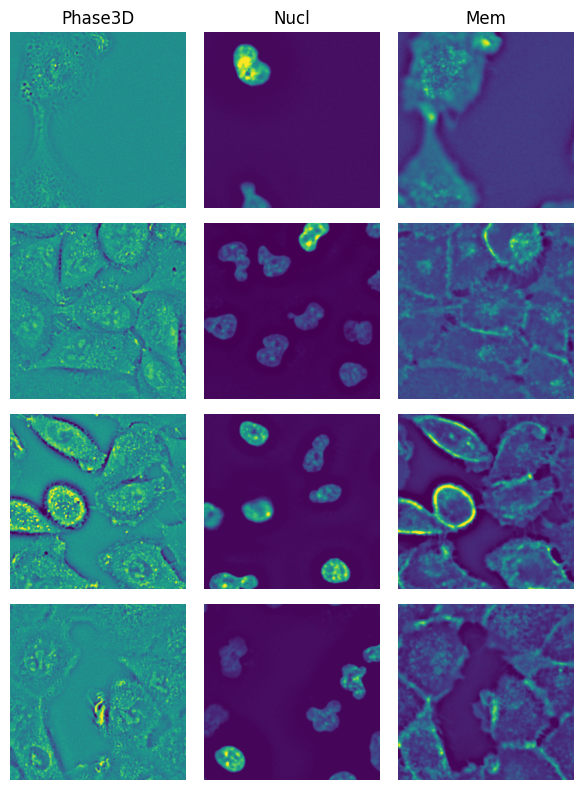

In [32]:
# Visualize in Jupyter
log_batch_jupyter(batch)

<div class="alert alert-warning">
<h3> Question for Task 1.3 </h3>
1. How do they make the model more robust to imaging parameters or conditions
without having to acquire data for every possible condition? <br> By performing augmentations (e.g., rotations, crops, scaling, blurring).
</div>


<div class="alert alert-info">

### Task 1.3
Add the following augmentations:
- Add augmentations to rotate about $\pi$ around z-axis, 30% scale in y,x,
shearing of 10% and no padding with zeros with a probablity of 80%.
- Add a Gaussian noise with a mean of 0.0 and standard deviation of 0.3 with a probability of 50%.

HINT: `RandAffined()` and `RandGaussianNoised()` are from
`viscy.transforms` [here](https://github.com/mehta-lab/VisCy/blob/main/viscy/transforms.py). You can look at the docs by running `RandAffined?`.<br><br>
*Note these are MONAI transforms that have been redefined for VisCy.*
[Compare your choice of augmentations by dowloading the pretrained models and config files](https://github.com/mehta-lab/VisCy/releases/download/v0.1.0/VisCy-0.1.0-VS-models.zip).
</div>

In [33]:
# Here we turn on data augmentation and rerun setup
# #######################
# ##### DONE ########
# #######################
# HINT: Run dataset.channel_names
source_channel = ["Phase3D"]
target_channel = ["Nucl", "Mem"]

augmentations = [
    RandWeightedCropd(
        keys=source_channel + target_channel,
        spatial_size=(1, 384, 384),
        num_samples=2,
        w_key=target_channel[0],
    ),
    # #######################s
    # ##### DONE  ########
    # #######################
    ## DONE: Add Random Affine Transorms
    ## Write code below
    RandAffined(
        keys=source_channel + target_channel,
        rotate_range=[np.pi, 0.0, 0.0],  # z rotation
        scale_range=[0.0, 0.3, 0.3],  # scale y,x
        prob=0.8,
        padding_mode="zeros",
        shear_range=[0.0, 0.01, 0.01],  # Shear y,x
    ),
    # #######################
    RandAdjustContrastd(keys=source_channel, prob=0.5, gamma=(0.8, 1.2)),
    RandScaleIntensityd(keys=source_channel, factors=0.5, prob=0.5),
    # #######################
    # ##### DONE  ########
    # #######################
    ## DONE: Add Random Gaussian Noise
    ## Write code below
    RandGaussianNoised(
        keys=source_channel, 
        prob=0.5, 
        mean=0.0, 
        std=0.3,
    ),
    # #######################
    RandGaussianSmoothd(
        keys=source_channel,
        sigma_x=(0.25, 0.75),
        sigma_y=(0.25, 0.75),
        sigma_z=(0.0, 0.0),
        prob=0.5,
    ),
]

normalizations = [
    NormalizeSampled(
        keys=source_channel,
        level="fov_statistics",
        subtrahend="mean",
        divisor="std",
    ),
    NormalizeSampled(
        keys=target_channel,
        level="fov_statistics",
        subtrahend="median",
        divisor="iqr",
    ),
]

data_module.augmentations = augmentations
data_module.setup("fit")

# get the new data loader with augmentation turned on
augmented_train_dataloader = data_module.train_dataloader()

# Draw batches and write to tensorboard
writer = SummaryWriter(log_dir=f"{log_dir}/view_batch")
augmented_batch = next(iter(augmented_train_dataloader))
log_batch_tensorboard(augmented_batch, 0, writer, "augmentation/some")
writer.close()

<div class="alert alert-warning">
<h3> Question for Task 1.3 </h3>
    
1. Look at your tensorboard. Can you tell the augmentations were applied to the sample batch? Compare the batch with and without augmentations. Gaussian blur and rotations are the most visible ones.
2. Are these augmentations good enough? What else would you add? I would also add vertical and horizontal flips. I think those are the only ones missing from the standard [transformations](https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py). I considered JPEG but its algorightm is based on human perception and that should be irrelevant in this context. I would also probably restrict rotations to multiples of pi degrees to avoid pixel interpolation, but potentially increase its rate.
</div>



Visualize directly on Jupyter

<Figure size 640x480 with 0 Axes>

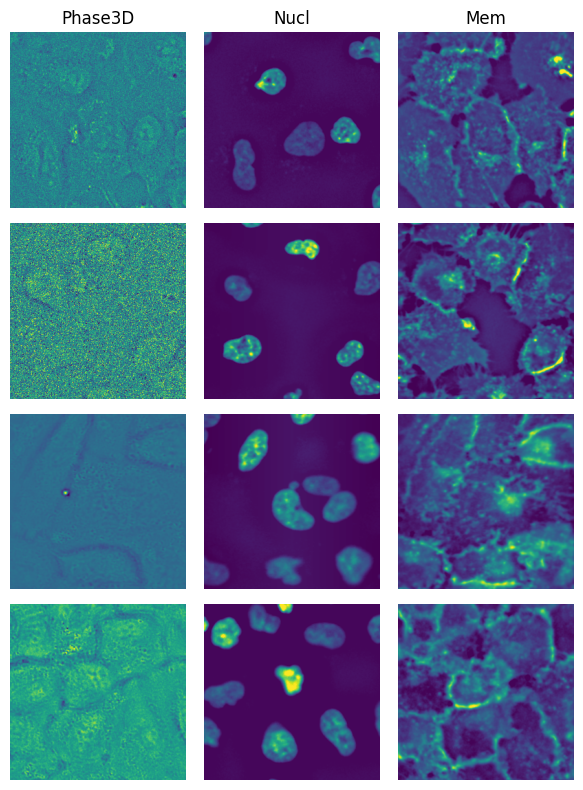

In [34]:
log_batch_jupyter(augmented_batch)

## Train a 2D U-Net model to predict nuclei and membrane from phase.
### Constructing a 2D UNeXt2 using VisCy

<div class="alert alert-info">

### Task 1.5
- Run the next cell to instantiate the `UNeXt2_2D` model
  - Configure the network for the phase (source) to fluorescence cell nuclei and membrane (targets) regression task.
  - Call the VSUNet with the `"UNeXt2_2D"` architecture.
- Run the next cells to instantiate data module and trainer.
  - Add the source channel name and the target channel names
- Start the training <br>

<b> Note </b> <br>
See ``viscy.unet.networks.Unet2D.Unet2d`` ([source code](https://github.com/mehta-lab/VisCy/blob/7c5e4c1d68e70163cf514d22c475da8ea7dc3a88/viscy/unet/networks/Unet2D.py#L7)) to learn more about the configuration.
</div>

In [35]:
# Create a 2D UNet.
GPU_ID = 0

BATCH_SIZE = 16
YX_PATCH_SIZE = (256, 256)

# #######################
# ##### DONE ########
# #######################
# Dictionary that specifies key parameters of the model.
phase2fluor_config = dict(
    in_channels=1,  # DONE how many input channels are we feeding? Hint: int,
    out_channels=2,  # DONE how many output channels are we solving for? Hint: int,
    encoder_blocks=[3, 3, 9, 3],
    dims=[96, 192, 384, 768],
    decoder_conv_blocks=2,
    stem_kernel_size=(1, 2, 2),
    in_stack_depth=1,  # 1, as there are no z-stacks
    pretraining=False,
)

# #######################
# ##### DONE ########
# #######################
phase2fluor_model = VSUNet(
    architecture="UNeXt2_2D",  # 2D UNeXt2 architecture
    model_config=phase2fluor_config.copy(),
    loss_function=MixedLoss(l1_alpha=0.5, l2_alpha=0.0, ms_dssim_alpha=0.5),
    schedule="WarmupCosine",
    lr=6e-4,
    log_batches_per_epoch=5,  # Number of samples from each batch to log to tensorboard.
    freeze_encoder=False,
)

# #######################
# ##### DONE ########
# #######################
# HINT: Run dataset.channel_names
source_channel = ["Phase3D"]
target_channel = ["Nucl", "Mem"]

# Setup the data module.
phase2fluor_2D_data = HCSDataModule(
    data_path,
    architecture="UNeXt2_2D",  # 2D UNeXt2 architecture
    source_channel=source_channel,
    target_channel=target_channel,
    z_window_size=1,
    split_ratio=0.8,
    batch_size=BATCH_SIZE,
    num_workers=8,
    yx_patch_size=YX_PATCH_SIZE,
    augmentations=augmentations,
    normalizations=normalizations,
)
phase2fluor_2D_data.setup("fit")
# fast_dev_run runs a single batch of data through the model to check for errors.
trainer = VSTrainer(
    accelerator="gpu", devices=[GPU_ID], precision="16-mixed", fast_dev_run=True
)

# trainer class takes the model and the data module as inputs.
trainer.fit(phase2fluor_model, datamodule=phase2fluor_2D_data)

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                  | Params | Mode  | In sizes            | Out sizes          
------------------------------------------------------------------------------------------------------------
0 | model         | FullyConvolutionalMAE | 31.2 M | train | [1, 1, 1, 256, 256] | [1, 2, 1, 256, 256]
1 | loss_function | MixedLoss             | 0      | train | ?                   | ?                  
----------------------------------------------------

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


## View model graph.

PyTorch uses dynamic graphs under the hood.
The graphs are constructed on the fly.
This is in contrast to TensorFlow,
where the graph is constructed before the training loop and remains static.
In other words, the graph of the network can change with every forward pass.
Therefore, we need to supply an input tensor to construct the graph.
The input tensor can be a random tensor of the correct shape and type.
We can also supply a real image from the dataset.
The latter is more useful for debugging.

<div class="alert alert-info">

### Task 1.5
Run the next cell to generate a graph representation of the model architecture.
</div>

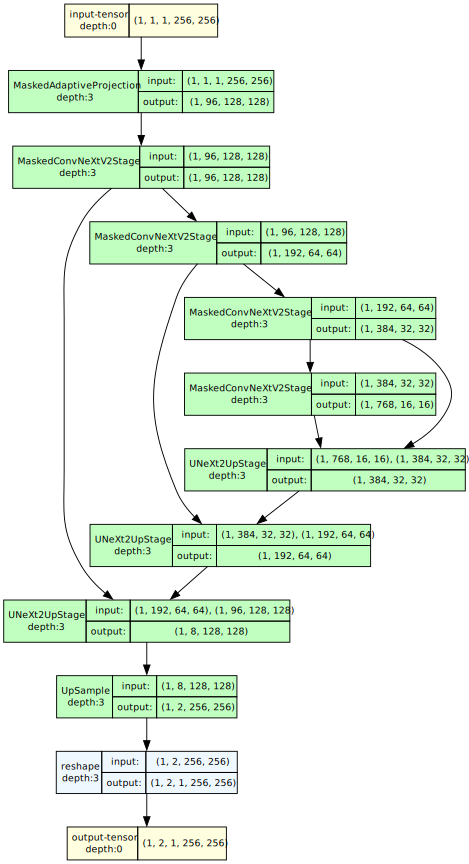

In [15]:
# visualize graph of phase2fluor model as image.
model_graph_phase2fluor = torchview.draw_graph(
    phase2fluor_model,
    phase2fluor_2D_data.train_dataset[0]["source"][0].unsqueeze(dim=0),
    roll=True,
    depth=3,  # adjust depth to zoom in.
    device="cpu",
    # expand_nested=True,
    save_graph=True,
    filename="tmp",
)
# Print the image of the model.
model_graph_phase2fluor.visual_graph

<div class="alert alert-warning">

### Question:
Can you recognize the UNet structure and skip connections in this graph visualization? Yes, the yx goes 256-(down)->128->64->32-(up)->64->128->256.
The depth goes high and then back down. The skip connections go top bottom.
</div>


<div class="alert alert-info">

<h3> Task 1.6 </h3>
Start training by running the following cell. Check the new logs on the tensorboard.
</div>

In [16]:
# Check if GPU is available
# You can check by typing `nvidia-smi`
GPU_ID = 0

n_samples = len(phase2fluor_2D_data.train_dataset)
steps_per_epoch = n_samples // BATCH_SIZE  # steps per epoch.
n_epochs = 100  # Set this to 80-100 or the number of epochs you want to train for.

trainer = VSTrainer(
    accelerator="gpu",
    devices=[GPU_ID],
    max_epochs=n_epochs,
    precision="16-mixed",
    log_every_n_steps=steps_per_epoch // 2,
    # log losses and image samples 2 times per epoch.
    logger=TensorBoardLogger(
        save_dir=log_dir,
        # lightning trainer transparently saves logs and model checkpoints in this directory.
        name="phase2fluor",
        log_graph=True,
    ),
)
# Launch training and check that loss and images are being logged on tensorboard.
trainer.fit(phase2fluor_model, datamodule=phase2fluor_2D_data)

# Move the model to the GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
phase2fluor_model.to(device)

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                  | Params | Mode  | In sizes            | Out sizes          
------------------------------------------------------------------------------------------------------------
0 | model         | FullyConvolutionalMAE | 31.2 M | train | [1, 1, 1, 256, 256] | [1, 2, 1, 256, 256]
1 | loss_function | MixedLoss             | 0      | train | ?                   | ?                  
------------------------------------------------------------------------------------------------------------
31.2 M    Trainable params
0         Non-trainable params
31.2 

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


VSUNet(
  (model): FullyConvolutionalMAE(
    (encoder): MaskedMultiscaleEncoder(
      (stem): MaskedAdaptiveProjection(
        (conv3d): Conv3d(1, 96, kernel_size=(1, 2, 2), stride=(1, 2, 2))
        (conv2d): Conv2d(1, 96, kernel_size=(2, 2), stride=(2, 2))
        (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (stages): ModuleList(
        (0): MaskedConvNeXtV2Stage(
          (downsample): Identity()
          (blocks): ModuleList(
            (0-2): 3 x MaskedConvNeXtV2Block(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96, bias=False)
              (layernorm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (mlp): GlobalResponseNormMlp(
                (fc1): Linear(in_features=96, out_features=384, bias=True)
                (act): GELU(approximate='none')
                (drop1): Dropout(p=0.0, inplace=False)
                (grn): GlobalResponseNorm()
                (fc2): Li

<div class="alert alert-success">

<h2> Checkpoint 1 </h2>

While your model is training, let's think about the following questions:<br>
<ul>
<li>What is the information content of each channel in the dataset?</li>
    - The phase contrast of the image, which tends to reveal cellular structures more easily than traditional bright field imaging.
    - The nuclear channel, which highlights the contents of the nucleus in the cell.
    - The cell membrane, which indicates
<li>How would you use image translation models?</li>
    First, to improve downstream tasks, such as segmentation and classification. I would also featurize the virtual staining channels to try to get more information on these stains.
<li>What can you try to improve the performance of each model?</li>
    - 3D models: I could use existing models of 
    - 2D models: 
</ul>

Now the training has started,
we can come back after a while and evaluate the performance!

</div>

# Part 2: Assess your trained model

Now we will look at some metrics of performance of previous model.
We typically evaluate the model performance on a held out test data.
We will use the following metrics to evaluate the accuracy of regression of the model:

- [Person Correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient).
- [Structural similarity](https://en.wikipedia.org/wiki/Structural_similarity) (SSIM).

You should also look at the validation samples on tensorboard
(hint: the experimental data in nuclei channel is imperfect.)

<div class="alert alert-info">

<h3> Task 2.1 Define metrics </h3>

For each of the above metrics, write a brief definition of what they are and what they mean
for this image translation task. Use your favorite search engine and/or resources.

</div>

```
#######################
##### DONE ############
#######################

```

- Pearson Correlation: A coefficient representing how well the relationship between the variables can be described by a straight line. It ranges between -1 and 1. 1 means a 1:1 straight line and numbers closer to zero entail no correlation between the variables, and -1 means negative correlation. For image translation it can be used to group the pixel-wise distances between two images and can be used to evaluate predictions vs ground truth. I have used it in colocalization analysis of intracellular proteins.

- Structural similarity: It is an index showing index similarity. It considers changes in structural information, luminance, and contrast to provide a more accurate assessment of perceived image quality compared to traditional metrics, it perception based, which is one of the differentiators between this and Pearson. 

### Let's compute metrics directly and plot below.

<div class="alert alert-danger">
If you weren't able to train or training didn't complete please run the following lines to load the latest checkpoint <br>

```python
phase2fluor_model_ckpt = natsorted(glob(
   str(top_dir / "06_image_translation/logs/phase2fluor/version*/checkpoints/*.ckpt")
))[-1]
```
<br>
NOTE: if their model didn't go past epoch 5, lost their checkpoint, or didnt train anything.
Run the following:

```python
phase2fluor_model_ckpt = natsorted(glob(
 str(top_dir/"06_image_translation/backup/phase2fluor/version_0/checkpoints/*.ckpt")
))[-1]
```

```python
phase2fluor_config = dict(
    in_channels=1,
    out_channels=2,
    encoder_blocks=[3, 3, 9, 3],
    dims=[96, 192, 384, 768],
    decoder_conv_blocks=2,
    stem_kernel_size=(1, 2, 2),
    in_stack_depth=1,
    pretraining=False,
)
Load the model checkpoint
phase2fluor_model = VSUNet.load_from_checkpoint(
    phase2fluor_model_ckpt,
    architecture="UNeXt2_2D",
    model_config = phase2fluor_config,
    accelerator='gpu'
)
````
</div>

In [17]:
# Setup the test data module.
test_data_path = get_data(
    "test"
)  # top_dir / "06_image_translation/test/a549_hoechst_cellmask_test.zarr"
source_channel = ["Phase3D"]
target_channel = ["Nucl", "Mem"]

test_data = HCSDataModule(
    test_data_path,
    source_channel=source_channel,
    target_channel=target_channel,
    z_window_size=1,
    batch_size=1,
    num_workers=8,
    architecture="UNeXt2",
)
test_data.setup("test")

test_metrics = pd.DataFrame(
    columns=["pearson_nuc", "SSIM_nuc", "pearson_mem", "SSIM_mem"]
)

Computing metrics per sample: 100%|███████████████| 7/7 [00:08<00:00,  1.25s/it]


<Axes: >

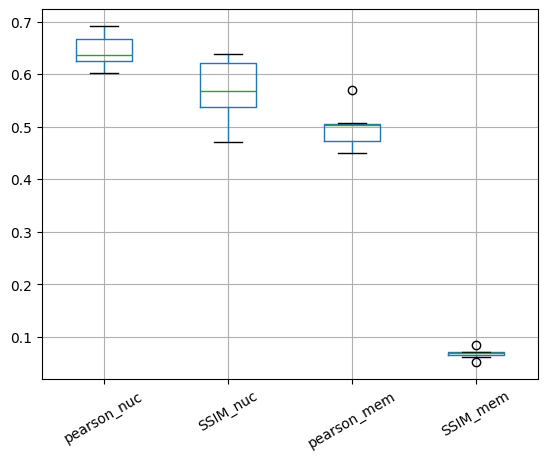

In [18]:
# Compute metrics directly and plot here.
def normalize_fov(input: ArrayLike):
    "Normalizing the fov with zero mean and unit variance"
    mean = np.mean(input)
    std = np.std(input)
    return (input - mean) / std


for i, sample in enumerate(
    tqdm(test_data.test_dataloader(), desc="Computing metrics per sample")
):
    phase_image = sample["source"].to(phase2fluor_model.device)
    with torch.inference_mode():  # turn off gradient computation.
        predicted_image = phase2fluor_model(phase_image)

    target_image = (
        sample["target"].cpu().numpy().squeeze(0)
    )  # Squeezing batch dimension.
    predicted_image = predicted_image.cpu().numpy().squeeze(0)
    phase_image = phase_image.cpu().numpy().squeeze(0)
    target_mem = normalize_fov(target_image[1, 0, :, :])
    target_nuc = normalize_fov(target_image[0, 0, :, :])
    # slicing channel dimension, squeezing z-dimension.
    predicted_mem = normalize_fov(predicted_image[1, :, :, :].squeeze(0))
    predicted_nuc = normalize_fov(predicted_image[0, :, :, :].squeeze(0))

    # Compute SSIM and pearson correlation.
    ssim_nuc = metrics.structural_similarity(target_nuc, predicted_nuc, data_range=1)
    ssim_mem = metrics.structural_similarity(target_mem, predicted_mem, data_range=1)
    pearson_nuc = np.corrcoef(target_nuc.flatten(), predicted_nuc.flatten())[0, 1]
    pearson_mem = np.corrcoef(target_mem.flatten(), predicted_mem.flatten())[0, 1]

    test_metrics.loc[i] = {
        "pearson_nuc": pearson_nuc,
        "SSIM_nuc": ssim_nuc,
        "pearson_mem": pearson_mem,
        "SSIM_mem": ssim_mem,
    }

# Plot the following metrics
test_metrics.boxplot(
    column=["pearson_nuc", "SSIM_nuc", "pearson_mem", "SSIM_mem"],
    rot=30,
)

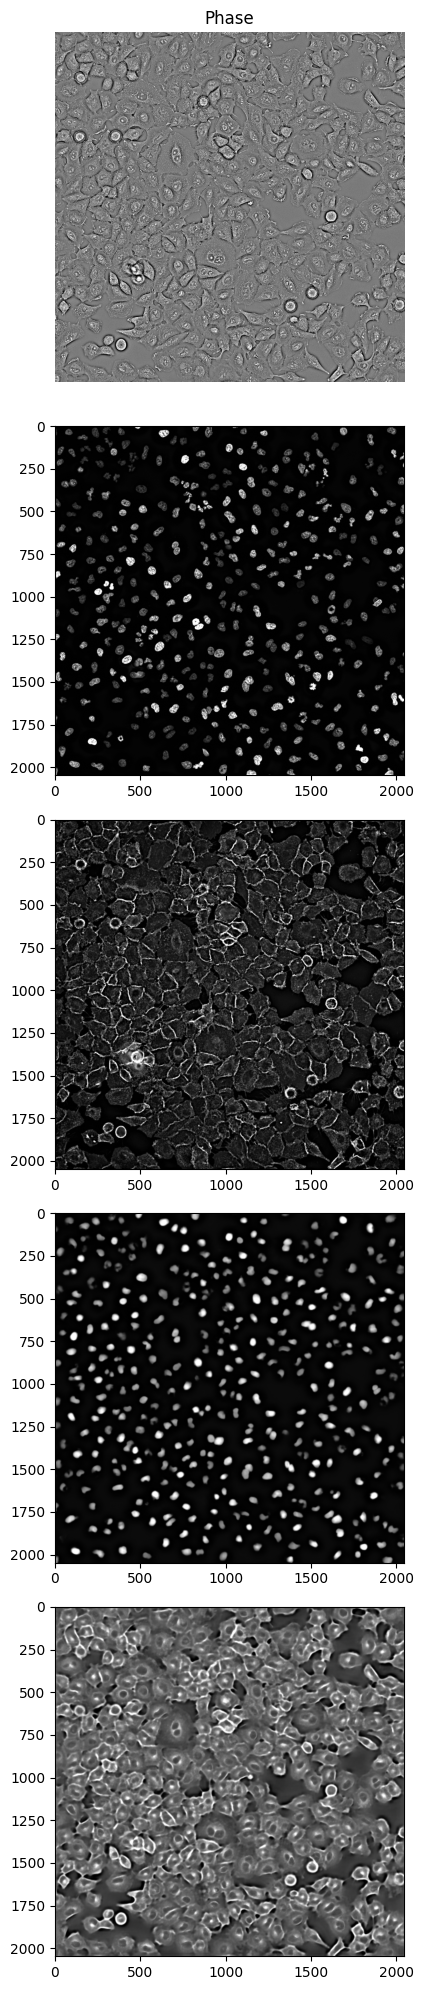

In [19]:
# Adjust the image to the 0.5-99.5 percentile range.
def process_image(image):
    p_low, p_high = np.percentile(image, (0.5, 99.5))
    return np.clip(image, p_low, p_high)


# Plot the predicted image vs target image.
channel_titles = [
    "Phase",
    "Target Nuclei",
    "Target Membrane",
    "Predicted Nuclei",
    "Predicted Membrane",
]
fig, axes = plt.subplots(5, 1, figsize=(20, 20))

# Get a writer to output the images into tensorboard and plot the source, predictions and target images
for i, sample in enumerate(test_data.test_dataloader()):
    # Plot the phase image
    phase_image = sample["source"]
    channel_image = phase_image[0, 0, 0]
    p_low, p_high = np.percentile(channel_image, (0.5, 99.5))
    channel_image = np.clip(channel_image, p_low, p_high)
    axes[0].imshow(channel_image, cmap="gray")
    axes[0].axis("off")
    axes[0].set_title(channel_titles[0])

    with torch.inference_mode():  # turn off gradient computation.
        predicted_image = (
            phase2fluor_model(phase_image.to(phase2fluor_model.device))
            .cpu()
            .numpy()
            .squeeze(0)
        )

    target_image = sample["target"].cpu().numpy().squeeze(0)
    phase_raw = process_image(phase_image[0, 0, 0])
    predicted_nuclei = process_image(predicted_image[0, 0])
    predicted_membrane = process_image(predicted_image[1, 0])
    target_nuclei = process_image(target_image[0, 0])
    target_membrane = process_image(target_image[1, 0])
    # Concatenate all images side by side
    combined_image = np.concatenate(
        (
            phase_raw,
            predicted_nuclei,
            predicted_membrane,
            target_nuclei,
            target_membrane,
        ),
        axis=1,
    )

    # Plot the phase,target nuclei, target membrane, predicted nuclei, predicted membrane
    axes[1].imshow(target_nuclei, cmap="gray")
    axes[2].imshow(target_membrane, cmap="gray")
    axes[3].imshow(predicted_nuclei, cmap="gray")
    axes[4].imshow(predicted_membrane, cmap="gray")

    plt.tight_layout()
    plt.savefig("test.png")
    plt.show()
    break

<div class="alert alert-info">

<h3> Task 2.2 Loading the pretrained model VSCyto2D </h3>
Here we will compare your model with the VSCyto2D pretrained model by computing the pixel-based metrics and segmentation-based metrics.

<ul>
<li>When you ran the `setup.sh` you also downloaded the models in `/06_image_translation/pretrained_models/VSCyto2D/*.ckpt`</li>
<li>Load the <b>VSCyto2 model</b> model checkpoint and the configuration file</li>
<li>Compute the pixel-based metrics and segmentation-based metrics between the model you trained and the pretrained model</li>
</ul>
<br>

</div>

In [20]:
#################
##### DONE ######
#################
# Let's load the pretrained model checkpoint
# pretrained_model_ckpt = top_dir/...## Add the path to the "VSCyto2D/epoch=399-step=23200.ckpt"
pretrained_model_ckpt = get_data("pretrained_ckpt")

# DONE: Load the phase2fluor_config just like the model you trained
phase2fluor_config = dict(
    in_channels=1,  # DONE how many input channels are we feeding? Hint: int,
    out_channels=2,  # DONE how many output channels are we solving for? Hint: int,
    encoder_blocks=[3, 3, 9, 3],
    dims=[96, 192, 384, 768],
    decoder_conv_blocks=2,
    stem_kernel_size=(1, 2, 2),
    in_stack_depth=1,  # 1, as there are no z-stacks
    pretraining=False,
)


# DONE: Load the checkpoint. Write the architecture name. HINT: look at the previous config.
pretrained_phase2fluor = VSUNet.load_from_checkpoint(
    pretrained_model_ckpt,
    architecture="UNeXt2_2D",
    model_config=phase2fluor_config,
    accelerator="gpu",
)
# DONE: Setup the dataloader in evaluation/predict mode
#
pretrained_phase2fluor.eval()

VSUNet(
  (model): FullyConvolutionalMAE(
    (encoder): MaskedMultiscaleEncoder(
      (stem): MaskedAdaptiveProjection(
        (conv3d): Conv3d(1, 96, kernel_size=(1, 2, 2), stride=(1, 2, 2))
        (conv2d): Conv2d(1, 96, kernel_size=(2, 2), stride=(2, 2))
        (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (stages): ModuleList(
        (0): MaskedConvNeXtV2Stage(
          (downsample): Identity()
          (blocks): ModuleList(
            (0-2): 3 x MaskedConvNeXtV2Block(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96, bias=False)
              (layernorm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (mlp): GlobalResponseNormMlp(
                (fc1): Linear(in_features=96, out_features=384, bias=True)
                (act): GELU(approximate='none')
                (drop1): Dropout(p=0.0, inplace=False)
                (grn): GlobalResponseNorm()
                (fc2): Li

<div class="alert alert-warning">
<h3> Question </h3>
    
1. Can we evaluate a model's performance based on their segmentations?<br>
   It is a reasonable proxy, since that is one of the downstream tasks we want to optimise for.
2. Look up IoU or Jaccard index, dice coefficient, and AP metrics. LINK:https://metrics-reloaded.dkfz.de/metric-library <br>
We will evaluate the performance of your trained model with a pre-trained model using pixel based metrics as above and
segmentation based metrics including (mAP@0.5, dice, accuracy and jaccard index). <br>

(I used a local LLM (qwen3:30b-a3b) to get compressed-enough definitions, and then I added some details.
- Jaccard Index (Also known as Intersection over Union or IoU): Measures the similarity between two sets by calculating the size of the intersection divided by the size of the union of the sets. 
- Dice Coefficient:  This is similar to the Jaccard index but emphasizes the overlap more heavily. It is defined as twice the size of the intersection divided by the sum of the sizes of the two sets.
- Average Precision: Metric used to evaluate the precision-recall trade-off for object detection tasks. It summarizes the precision-recall curve by calculating the average precision across different recall levels. 

</div>

### Let's compute the metrics for the test dataset
Before you run the following code, make sure you have the pretrained model loaded and the test data is ready.

The following code will compute the following:
- the pixel-based metrics  (pearson correlation, SSIM)
- segmentation-based metrics (mAP@0.5, dice, accuracy, jaccard index)

#### Note:
- The segmentation-based metrics are computed using the cellpose stock `nuclei` model
- The metrics will be store in the `test_pixel_metrics` and `test_segmentation_metrics` dataframes
- The segmentations will be stored in the `segmentation_store` zarr file
- Analyze the code while it runs.

In [21]:
# Define the function to compute the cellpose segmentation
def cellpose_segmentation(
    prediction: ArrayLike, target: ArrayLike
) -> Tuple[torch.ShortTensor]:
    # NOTE these are hardcoded for this notebook and A549 dataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cp_nuc_kwargs = {
        # "diameter": 65,
        "cellprob_threshold": 0.0,
    }
    cellpose_model = models.CellposeModel(
        gpu=True,
        # model_type='nuclei', # deprecated in cellpose 4
        device=torch.device(device),
    )
    pred_label, _, _ = cellpose_model.eval(prediction, **cp_nuc_kwargs)
    target_label, _, _ = cellpose_model.eval(target, **cp_nuc_kwargs)

    pred_label = pred_label.astype(np.int32)
    target_label = target_label.astype(np.int32)
    pred_label = torch.ShortTensor(pred_label)
    target_label = torch.ShortTensor(target_label)

    return (pred_label, target_label)

In [22]:
# Setting the paths for the test data and the output segmentation
test_data_path = get_data("test")
# / "06_image_translation/test/a549_hoechst_cellmask_test.zarr"
output_segmentation_path = (
    training_top_dir / "06_image_translation/pretrained_model_segmentations.zarr"
)

# Creating the dataframes to store the pixel and segmentation metrics
test_pixel_metrics = pd.DataFrame(
    columns=["model", "fov", "pearson_nuc", "SSIM_nuc", "pearson_mem", "SSIM_mem"]
)
test_segmentation_metrics = pd.DataFrame(
    columns=[
        "model",
        "fov",
        "masks_per_fov",
        "accuracy",
        "dice",
        "jaccard",
        "mAP",
        "mAP_50",
        "mAP_75",
        "mAR_100",
    ]
)
# Opening the test dataset
test_dataset = open_ome_zarr(test_data_path)

# Creating an output store for the predictions and segmentations
segmentation_store = open_ome_zarr(
    output_segmentation_path,
    channel_names=["nuc_pred", "mem_pred", "nuc_labels"],
    mode="w",
    layout="hcs",
)

# Looking at the test dataset
print("Test dataset:")
test_dataset.print_tree()
channel_names = test_dataset.channel_names
print(f"Channel names: {channel_names}")

# Finding the channel indices for the corresponding channel names
phase_cidx = channel_names.index("Phase3D")
nuc_cidx = channel_names.index("Nucl")
mem_cidx = channel_names.index("Mem")
nuc_label_cidx = channel_names.index("nuclei_segmentation")

Test dataset:
/
 └── 0
     └── 0
         ├── 0
         │   └── 0 (1, 5, 1, 2048, 2048) float64
         ├── 10
         │   └── 0 (1, 5, 1, 2048, 2048) float64
         ├── 15
         │   └── 0 (1, 5, 1, 2048, 2048) float64
         ├── 20
         │   └── 0 (1, 5, 1, 2048, 2048) float64
         ├── 25
         │   └── 0 (1, 5, 1, 2048, 2048) float64
         ├── 30
         │   └── 0 (1, 5, 1, 2048, 2048) float64
         └── 5
             └── 0 (1, 5, 1, 2048, 2048) float64
Channel names: ['Phase3D', 'Nucl', 'Mem', 'nuclei_segmentation', 'cell_segmentation']


In [23]:
def min_max_scale(image: ArrayLike) -> ArrayLike:
    "Normalizing the image using min-max scaling"
    min_val = image.min()
    max_val = image.max()
    return (image - min_val) / (max_val - min_val)


# Iterating through the test dataset positions to:
positions = list(test_dataset.positions())
total_positions = len(positions)

# Initializing the progress bar with the total number of positions
with tqdm(total=total_positions, desc="Processing FOVs") as pbar:
    # Iterating through the test dataset positions
    for fov, pos in positions:
        T, C, Z, Y, X = pos.data.shape
        Z_slice = slice(Z // 2, Z // 2 + 1)
        # Getting the arrays and the center slices
        phase_image = pos.data[:, phase_cidx : phase_cidx + 1, Z_slice]
        target_nucleus = pos.data[0, nuc_cidx : nuc_cidx + 1, Z_slice]
        target_membrane = pos.data[0, mem_cidx : mem_cidx + 1, Z_slice]
        target_nuc_label = pos.data[0, nuc_label_cidx : nuc_label_cidx + 1, Z_slice]

        # normalize the phase
        phase_image = normalize_fov(phase_image)

        # Running the prediction for both models
        phase_image = torch.from_numpy(phase_image).type(torch.float32)
        phase_image = phase_image.to(phase2fluor_model.device)
        with torch.inference_mode():  # turn off gradient computation.
            predicted_image_phase2fluor = phase2fluor_model(phase_image)
            predicted_image_pretrained = pretrained_phase2fluor(phase_image)

        # Loading and Normalizing the target and predictions for both models
        predicted_image_phase2fluor = (
            predicted_image_phase2fluor.cpu().numpy().squeeze(0)
        )
        predicted_image_pretrained = predicted_image_pretrained.cpu().numpy().squeeze(0)
        phase_image = phase_image.cpu().numpy().squeeze(0)

        target_mem = min_max_scale(target_membrane[0, 0])
        target_nuc = min_max_scale(target_nucleus[0, 0])

        # Normalizing the dataset using min-max scaling
        predicted_mem_phase2fluor = min_max_scale(
            predicted_image_phase2fluor[1, :, :, :].squeeze(0)
        )
        predicted_nuc_phase2fluor = min_max_scale(
            predicted_image_phase2fluor[0, :, :, :].squeeze(0)
        )

        predicted_mem_pretrained = min_max_scale(
            predicted_image_pretrained[1, :, :, :].squeeze(0)
        )
        predicted_nuc_pretrained = min_max_scale(
            predicted_image_pretrained[0, :, :, :].squeeze(0)
        )

        #######  Pixel-based Metrics ############
        # Compute SSIM and Pearson correlation for phase2fluor_model
        print("Computing Pixel Metrics")
        ssim_nuc_phase2fluor = metrics.structural_similarity(
            target_nuc, predicted_nuc_phase2fluor, data_range=1
        )
        ssim_mem_phase2fluor = metrics.structural_similarity(
            target_mem, predicted_mem_phase2fluor, data_range=1
        )
        pearson_nuc_phase2fluor = np.corrcoef(
            target_nuc.flatten(), predicted_nuc_phase2fluor.flatten()
        )[0, 1]
        pearson_mem_phase2fluor = np.corrcoef(
            target_mem.flatten(), predicted_mem_phase2fluor.flatten()
        )[0, 1]

        test_pixel_metrics.loc[len(test_pixel_metrics)] = {
            "model": "phase2fluor",
            "fov": fov,
            "pearson_nuc": pearson_nuc_phase2fluor,
            "SSIM_nuc": ssim_nuc_phase2fluor,
            "pearson_mem": pearson_mem_phase2fluor,
            "SSIM_mem": ssim_mem_phase2fluor,
        }
        # Compute SSIM and Pearson correlation for pretrained_model
        ssim_nuc_pretrained = metrics.structural_similarity(
            target_nuc, predicted_nuc_pretrained, data_range=1
        )
        ssim_mem_pretrained = metrics.structural_similarity(
            target_mem, predicted_mem_pretrained, data_range=1
        )
        pearson_nuc_pretrained = np.corrcoef(
            target_nuc.flatten(), predicted_nuc_pretrained.flatten()
        )[0, 1]
        pearson_mem_pretrained = np.corrcoef(
            target_mem.flatten(), predicted_mem_pretrained.flatten()
        )[0, 1]

        test_pixel_metrics.loc[len(test_pixel_metrics)] = {
            "model": "pretrained_phase2fluor",
            "fov": fov,
            "pearson_nuc": pearson_nuc_pretrained,
            "SSIM_nuc": ssim_nuc_pretrained,
            "pearson_mem": pearson_mem_pretrained,
            "SSIM_mem": ssim_mem_pretrained,
        }

        ###### Segmentation based metrics #########
        # Load the manually curated nuclei target label
        print("Computing Segmentation Metrics")
        pred_label, target_label = cellpose_segmentation(
            predicted_nuc_phase2fluor, target_nuc
        )
        # Binary labels
        pred_label_binary = pred_label > 0
        target_label_binary = target_label > 0

        # Use Coco metrics to get mean average precision
        coco_metrics = mean_average_precision(pred_label, target_label)
        # Find unique number of labels
        num_masks_fov = len(np.unique(pred_label))

        test_segmentation_metrics.loc[len(test_segmentation_metrics)] = {
            "model": "phase2fluor",
            "fov": fov,
            "masks_per_fov": num_masks_fov,
            "accuracy": accuracy(
                pred_label_binary, target_label_binary, task="binary"
            ).item(),
            "dice": dice(pred_label_binary, target_label_binary).item(),
            "jaccard": jaccard_index(
                pred_label_binary, target_label_binary, task="binary"
            ).item(),
            "mAP": coco_metrics["map"].item(),
            "mAP_50": coco_metrics["map_50"].item(),
            "mAP_75": coco_metrics["map_75"].item(),
            "mAR_100": coco_metrics["mar_100"].item(),
        }

        pred_label, target_label = cellpose_segmentation(
            predicted_nuc_pretrained, target_nuc
        )

        # Binary labels
        pred_label_binary = pred_label > 0
        target_label_binary = target_label > 0

        # Use Coco metrics to get mean average precision
        coco_metrics = mean_average_precision(pred_label, target_label)
        # Find unique number of labels
        num_masks_fov = len(np.unique(pred_label))

        test_segmentation_metrics.loc[len(test_segmentation_metrics)] = {
            "model": "phase2fluor_pretrained",
            "fov": fov,
            "masks_per_fov": num_masks_fov,
            "accuracy": accuracy(
                pred_label_binary, target_label_binary, task="binary"
            ).item(),
            "dice": dice(pred_label_binary, target_label_binary).item(),
            "jaccard": jaccard_index(
                pred_label_binary, target_label_binary, task="binary"
            ).item(),
            "mAP": coco_metrics["map"].item(),
            "mAP_50": coco_metrics["map_50"].item(),
            "mAP_75": coco_metrics["map_75"].item(),
            "mAR_100": coco_metrics["mar_100"].item(),
        }

        # Save the predictions and segmentations
        position = segmentation_store.create_position(*Path(fov).parts[-3:])
        output_array = np.zeros((T, 3, 1, Y, X), dtype=np.float32)
        output_array[0, 0, 0] = predicted_nuc_pretrained
        output_array[0, 1, 0] = predicted_mem_pretrained
        output_array[0, 2, 0] = np.array(pred_label)
        position.create_image("0", output_array)

        # Update the progress bar
        pbar.update(1)

# Close the OME-Zarr files
test_dataset.close()
segmentation_store.close()

Processing FOVs:   0%|                                    | 0/7 [00:00<?, ?it/s]

Computing Pixel Metrics
Computing Segmentation Metrics


Processing FOVs:  14%|████                        | 1/7 [00:39<03:57, 39.57s/it]

Computing Pixel Metrics
Computing Segmentation Metrics


Processing FOVs:  29%|████████                    | 2/7 [01:20<03:21, 40.27s/it]

Computing Pixel Metrics
Computing Segmentation Metrics


Processing FOVs:  43%|████████████                | 3/7 [01:55<02:32, 38.08s/it]

Computing Pixel Metrics
Computing Segmentation Metrics


Processing FOVs:  57%|████████████████            | 4/7 [02:38<02:00, 40.08s/it]

Computing Pixel Metrics
Computing Segmentation Metrics


Processing FOVs:  71%|████████████████████        | 5/7 [03:21<01:21, 40.99s/it]

Computing Pixel Metrics
Computing Segmentation Metrics


Processing FOVs:  86%|████████████████████████    | 6/7 [03:59<00:39, 39.84s/it]

Computing Pixel Metrics
Computing Segmentation Metrics


Processing FOVs: 100%|████████████████████████████| 7/7 [04:40<00:00, 40.10s/it]


In [24]:
# Save the test metrics into a dataframe
pixel_metrics_path = training_top_dir / "06_image_translation/VS_metrics_pixel.csv"
segmentation_metrics_path = (
    training_top_dir / "06_image_translation/VS_metrics_segments.csv"
)
test_pixel_metrics.to_csv(pixel_metrics_path)
test_segmentation_metrics.to_csv(segmentation_metrics_path)

<div class="alert alert-info">

<h3> Task 2.3 Compare the model's metrics </h3>
In the previous section, we computed the pixel-based metrics and segmentation-based metrics.
Now we will compare the performance of the model you trained with the pretrained model by plotting the boxplots.

After you plot the metrics answer the following:
<ul>
<li>What do these metrics tells us about the performance of the model?</li>
<li>How do you interpret the differences in the metrics between the models?</li>
<li>How is your model compared to the pretrained model? How can you improve it?</li>
</ul>
</div>

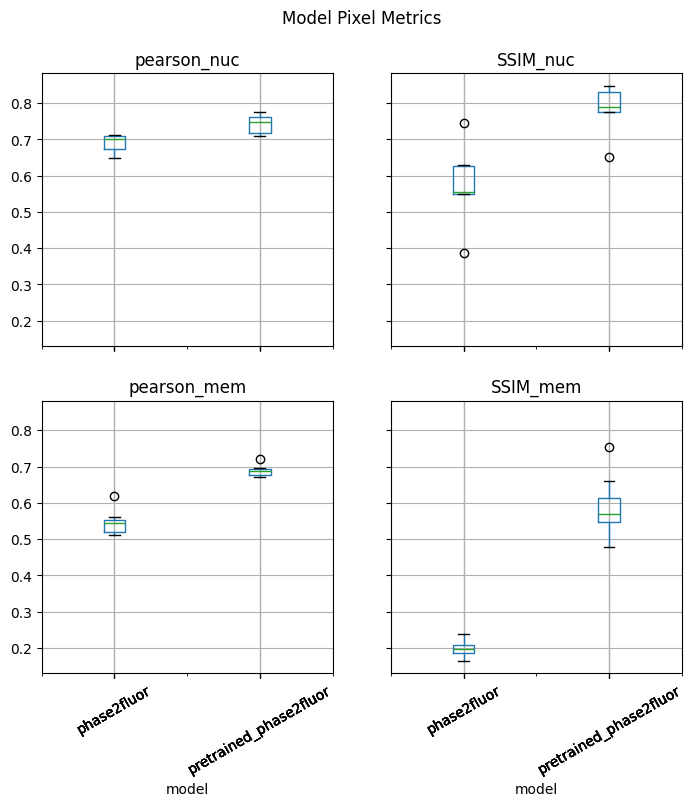

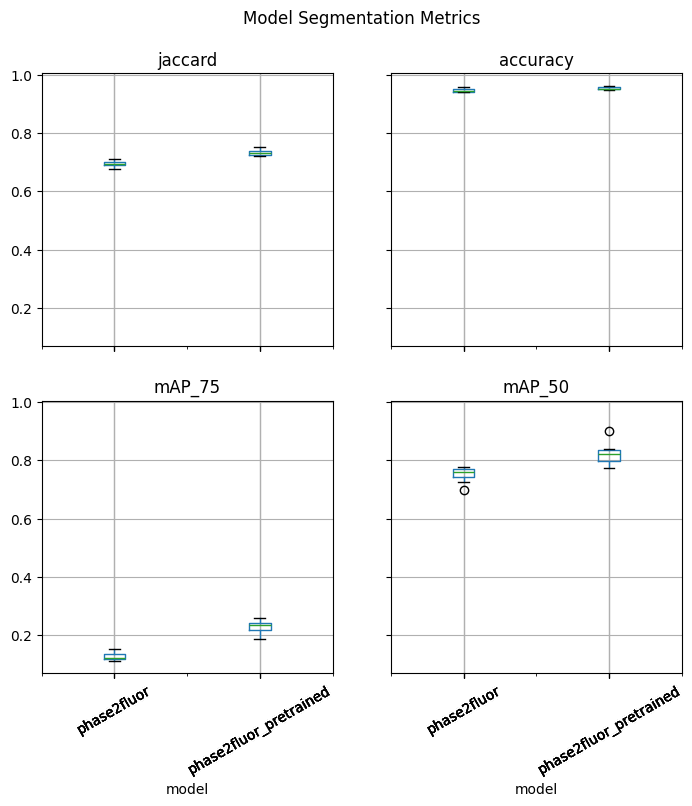

In [25]:
# Show boxplot of the metrics
# Boxplot of the metrics
test_pixel_metrics.boxplot(
    by="model",
    column=["pearson_nuc", "SSIM_nuc", "pearson_mem", "SSIM_mem"],
    rot=30,
    figsize=(8, 8),
)
plt.suptitle("Model Pixel Metrics")
plt.savefig("model_pixel_metrics.png")
plt.show()
# Show boxplot of the metrics
# Boxplot of the metrics
test_segmentation_metrics.boxplot(
    by="model",
    column=["jaccard", "accuracy", "mAP_75", "mAP_50"],
    rot=30,
    figsize=(8, 8),
)
plt.suptitle("Model Segmentation Metrics")
plt.savefig("model_seg_metrics.png")
plt.show()

<div class="alert alert-warning">
<h3>Questions</h3>
<ul>
<li> What do these metrics tells us about the performance of the model? </li>
<li> How do you interpret the differences in the metrics between the models? </li>
<li> How is your model compared to the pretrained model? How can you improve it? </li>
</ul>
</div>

<div class="alert alert-info">

### Plotting the predictions and segmentations
Here we will plot the predictions and segmentations side by side for the pretrained and trained models.<br>
<ul>
<li>How do yout model, the pretrained model and the ground truth compare?</li>
<li>How do the segmentations compare? </li>
</ul>
Feel free to modify the crop size and Y,X slicing to view different areas of the FOV
</div>

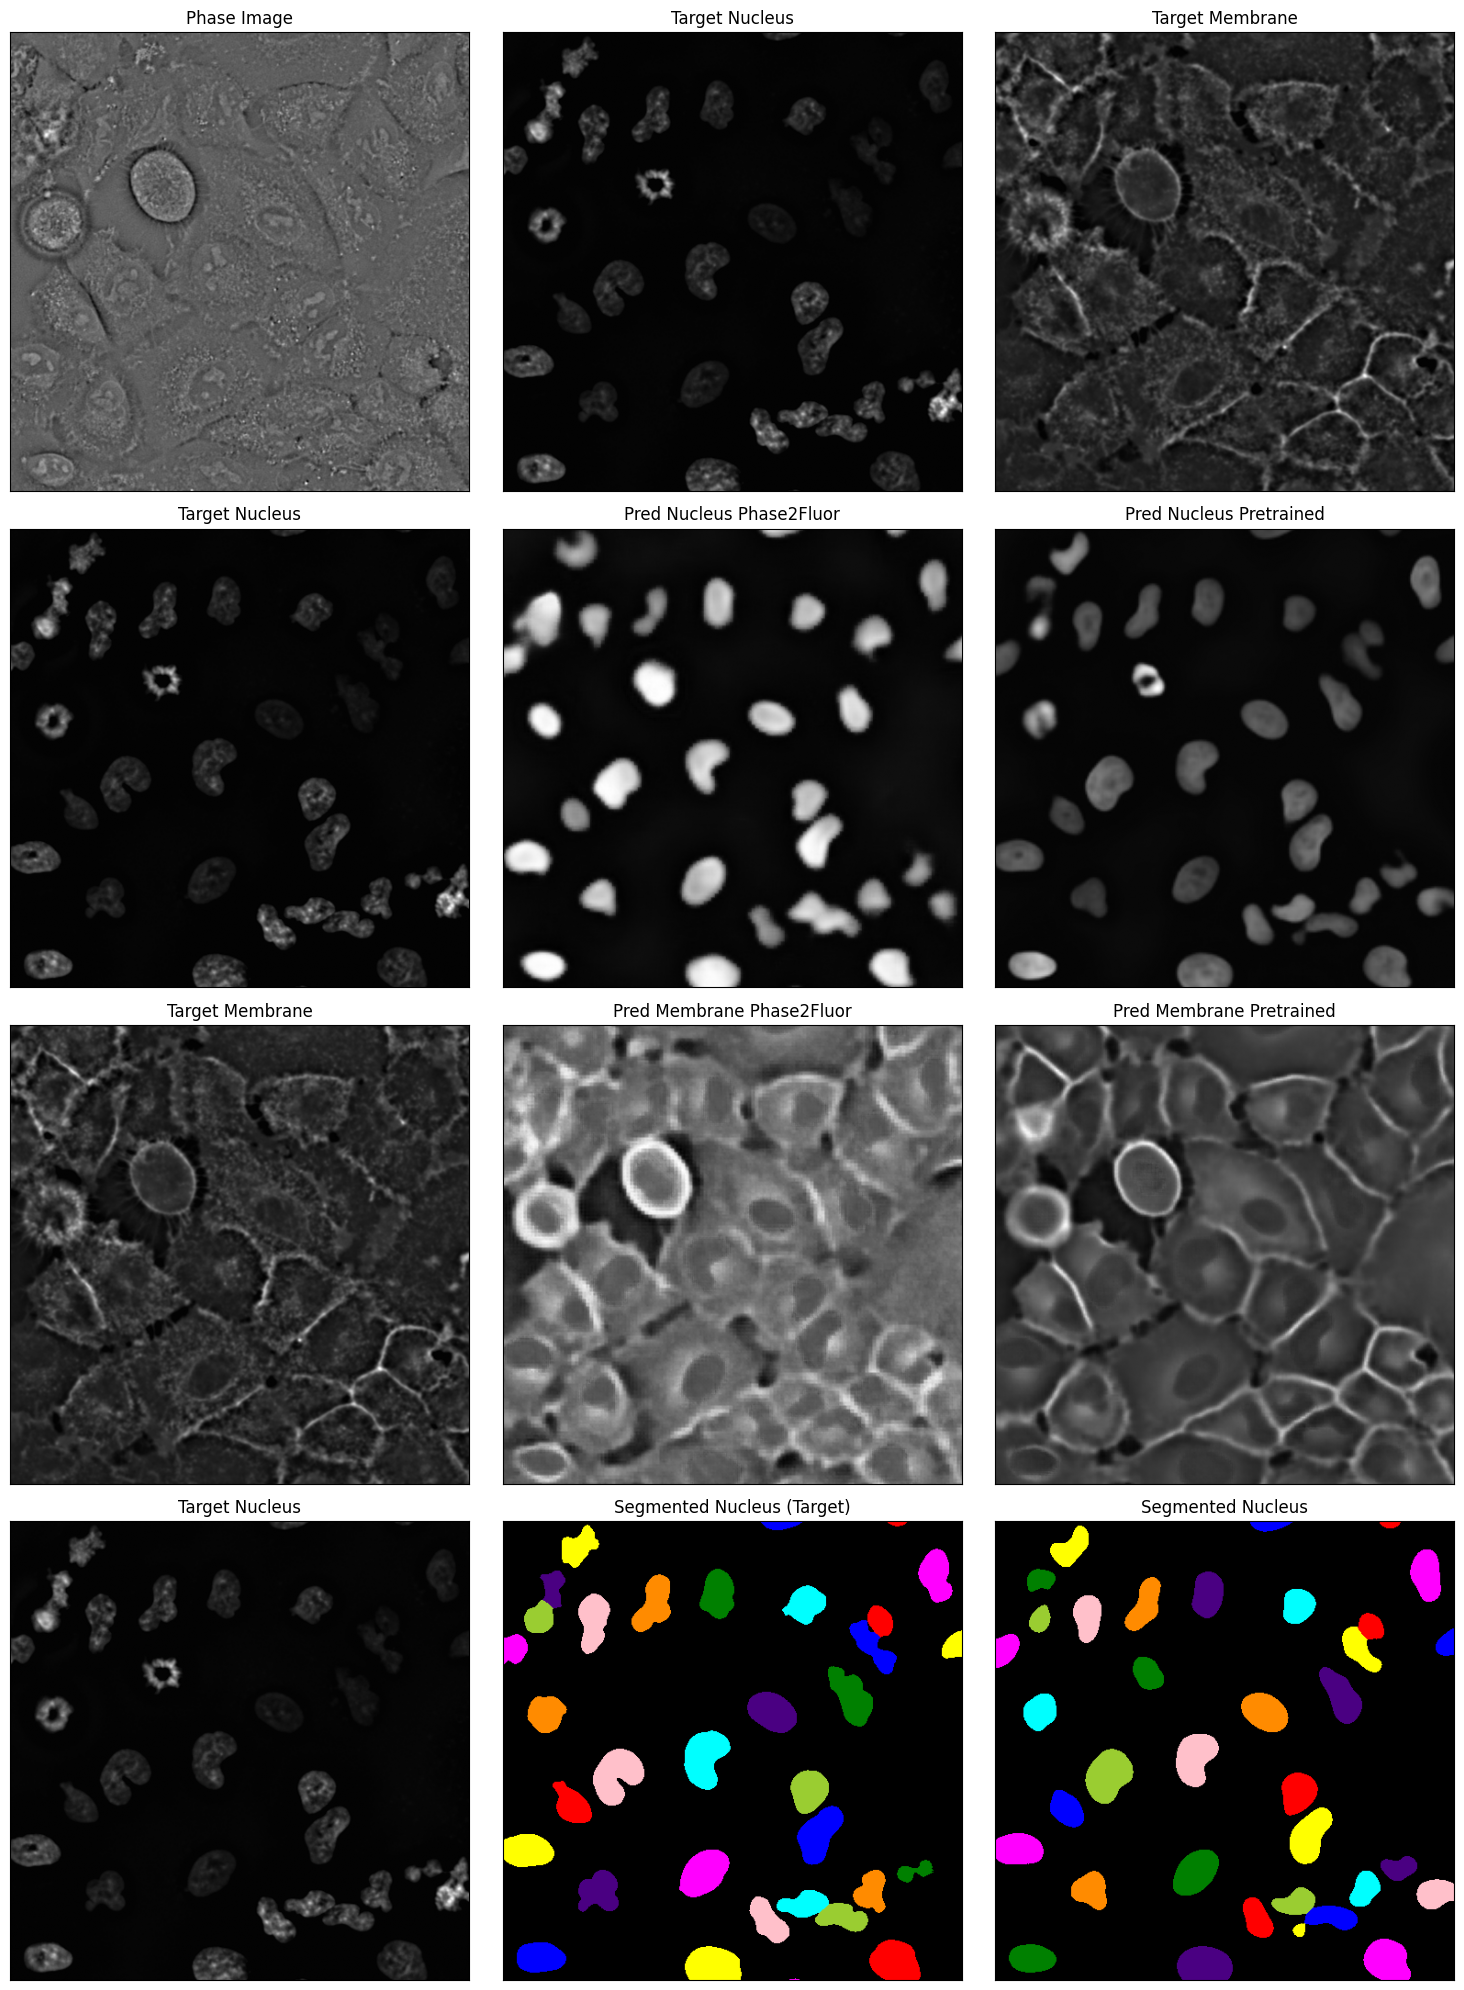

In [52]:

# Get the shape of the 2D image
Y, X = phase_image.shape[-2:]
######## TODO ##########
# Modify the crop size and Y,X slicing to view different areas of the FOV

crop = 500
y_slice = slice(Y // 2 - crop // 2, Y // 2 + crop // 2)
x_slice = slice(X // 2 - crop // 2, X // 2 + crop // 2)
#######################
# Plotting side by side comparisons
fig, axs = plt.subplots(4, 3, figsize=(15, 20))

# First row: phase_image, target_nuc, target_mem
axs[0, 0].imshow(phase_image[0, 0, y_slice, x_slice], cmap="gray")
axs[0, 0].set_title("Phase Image")
axs[0, 1].imshow(target_nuc[y_slice, x_slice], cmap="gray")
axs[0, 1].set_title("Target Nucleus")
axs[0, 2].imshow(target_mem[y_slice, x_slice], cmap="gray")
axs[0, 2].set_title("Target Membrane")

# Second row: target_nuc, pred_nuc_phase2fluor, pred_nuc_pretrained
axs[1, 0].imshow(target_nuc[y_slice, x_slice], cmap="gray")
axs[1, 0].set_title("Target Nucleus")
axs[1, 1].imshow(predicted_nuc_phase2fluor[y_slice, x_slice], cmap="gray")
axs[1, 1].set_title("Pred Nucleus Phase2Fluor")
axs[1, 2].imshow(predicted_nuc_pretrained[y_slice, x_slice], cmap="gray")
axs[1, 2].set_title("Pred Nucleus Pretrained")

# Third row: target_mem, pred_mem_phase2fluor, pred_mem_pretrained
axs[2, 0].imshow(target_mem[y_slice, x_slice], cmap="gray")
axs[2, 0].set_title("Target Membrane")
axs[2, 1].imshow(predicted_mem_phase2fluor[y_slice, x_slice], cmap="gray")
axs[2, 1].set_title("Pred Membrane Phase2Fluor")
axs[2, 2].imshow(predicted_mem_pretrained[y_slice, x_slice], cmap="gray")
axs[2, 2].set_title("Pred Membrane Pretrained")

# Fourth row: target_nuc, segment_nuc, segment_nuc2
axs[3, 0].imshow(target_nuc[y_slice, x_slice], cmap="gray")
axs[3, 0].set_title("Target Nucleus")
axs[3, 1].imshow(
    label2rgb(np.array(target_label[y_slice, x_slice], dtype="int")), cmap="gray"
)
axs[3, 1].set_title("Segmented Nucleus (Target)")
axs[3, 2].imshow(
    label2rgb(np.array(pred_label[y_slice, x_slice], dtype="int")), cmap="gray"
)
axs[3, 2].set_title("Segmented Nucleus")

# Hide axes ticks
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

<div class="alert alert-success">

<h2> Checkpoint 2 </h2>

Congratulations! You have completed the second checkpoint. You have:
- Visualized the predictions and segmentations of the model. <br>
- Evaluated the performance of the model using pixel-based metrics and segmentation-based metrics. <br>
- Compared the performance of the model you trained with the pretrained model. <br>

</div>

# Part 3: Visualizing the encoder and decoder features & exploring the model's range of validity

- In this section, we will visualize the encoder and decoder features of the model you trained.
- We will also explore the model's range of validity by looking at the feature maps of the encoder and decoder.


<div class="alert alert-info">
<h3> Task 3.1: Let's look at what the model is learning </h3>

- If you are unfamiliar with Principal Component Analysis (PCA), you can read up <a href="https://en.wikipedia.org/wiki/Principal_component_analysis">here</a> <br>
- Run the next cells. We will visualize the encoder feature maps of the trained model.
 We will use PCA to visualize the feature maps by mapping the first 3 principal components to a colormap `Color` <br>


</div>

In [27]:
"""
Script to visualize the encoder feature maps of a trained model.
Using PCA to visualize feature maps is inspired by
https://doi.org/10.48550/arXiv.2304.07193 (Oquab et al., 2023).
"""
from typing import NamedTuple

from matplotlib.patches import Rectangle
from monai.networks.layers import GaussianFilter
from skimage.exposure import rescale_intensity
from skimage.transform import downscale_local_mean
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def feature_map_pca(feature_map: np.array, n_components: int = 8) -> PCA:
    """
    Compute PCA on a feature map.
    :param np.array feature_map: (C, H, W) feature map
    :param int n_components: number of components to keep
    :return: PCA: fit sklearn PCA object
    """
    # (C, H, W) -> (C, H*W)
    feat = feature_map.reshape(feature_map.shape[0], -1)
    pca = PCA(n_components=n_components)
    pca.fit(feat)
    return pca


def pcs_to_rgb(feat: np.ndarray, n_components: int = 8) -> np.ndarray:
    pca = feature_map_pca(feat[0], n_components=n_components)
    pc_first_3 = pca.components_[:3].reshape(3, *feat.shape[-2:])
    return np.stack(
        [rescale_intensity(pc, out_range=(0, 1)) for pc in pc_first_3], axis=-1
    )

In [37]:
# Load the test dataset
test_data_path = get_data("test") #/ "06_image_translation/test/a549_hoechst_cellmask_test.zarr"
test_dataset = open_ome_zarr(test_data_path)

# Looking at the test dataset
print("Test dataset:")
test_dataset.print_tree()

Test dataset:
/
 └── 0
     └── 0
         ├── 0
         │   └── 0 (1, 5, 1, 2048, 2048) float64
         ├── 10
         │   └── 0 (1, 5, 1, 2048, 2048) float64
         ├── 15
         │   └── 0 (1, 5, 1, 2048, 2048) float64
         ├── 20
         │   └── 0 (1, 5, 1, 2048, 2048) float64
         ├── 25
         │   └── 0 (1, 5, 1, 2048, 2048) float64
         ├── 30
         │   └── 0 (1, 5, 1, 2048, 2048) float64
         └── 5
             └── 0 (1, 5, 1, 2048, 2048) float64


<div class="alert alert-info">

- Change the `fov` and `crop` size to visualize the feature maps of the encoder and decoder  <br>
Note: the crop should be a multiple of 384
</div>

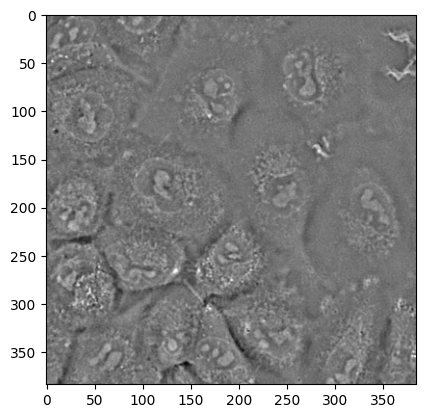

In [38]:
# Load one position
row = 0
col = 0
center_index = 2
n = 1
crop = 384 * n
fov = 10

# normalize phase
norm_meta = test_dataset.zattrs["normalization"]["Phase3D"]["dataset_statistics"]

# Get the OME-Zarr metadata
Y, X = test_dataset[f"0/0/{fov}"].data.shape[-2:]
test_dataset.channel_names
phase_idx = test_dataset.channel_names.index("Phase3D")
assert crop // 2 < Y and crop // 2 < Y, (
    "Crop size larger than the image. Check the image shape"
)

phase_img = test_dataset[f"0/0/{fov}/0"][
    :,
    phase_idx : phase_idx + 1,
    0:1,
    Y // 2 - crop // 2 : Y // 2 + crop // 2,
    X // 2 - crop // 2 : X // 2 + crop // 2,
]
fluo = test_dataset[f"0/0/{fov}/0"][
    0,
    1:3,
    0,
    Y // 2 - crop // 2 : Y // 2 + crop // 2,
    X // 2 - crop // 2 : X // 2 + crop // 2,
]

phase_img = (phase_img - norm_meta["median"]) / norm_meta["iqr"]
plt.imshow(phase_img[0, 0, 0], cmap="gray")

<div class="alert alert-info">
For the following tasks we will use the pretrained model to extract the encoder and decoder features <br>
Extra: If you are done with the whole checkpoint, you can try to look at what your trained model learned.
</div>

In [39]:

# Loading the pretrained model
pretrained_model_ckpt = get_data("pretrained_ckpt")
# (
#     top_dir / "06_image_translation/pretrained_models/VSCyto2D/epoch=399-step=23200.ckpt"
# )
# model config as before
phase2fluor_config = dict(
    in_channels=1,
    out_channels=2,
    encoder_blocks=[3, 3, 9, 3],
    dims=[96, 192, 384, 768],
    decoder_conv_blocks=2,
    stem_kernel_size=(1, 2, 2),
    in_stack_depth=1,
    pretraining=False,
)

# load model
model = VSUNet.load_from_checkpoint(
    pretrained_model_ckpt,
    architecture="UNeXt2_2D",
    model_config=phase2fluor_config.copy(),
    accelerator="gpu",
)

(1, 96, 192, 192)
(1, 192, 96, 96)
(1, 384, 48, 48)
(1, 768, 24, 24)
(1, 384, 48, 48)
(1, 192, 96, 96)
(1, 8, 192, 192)


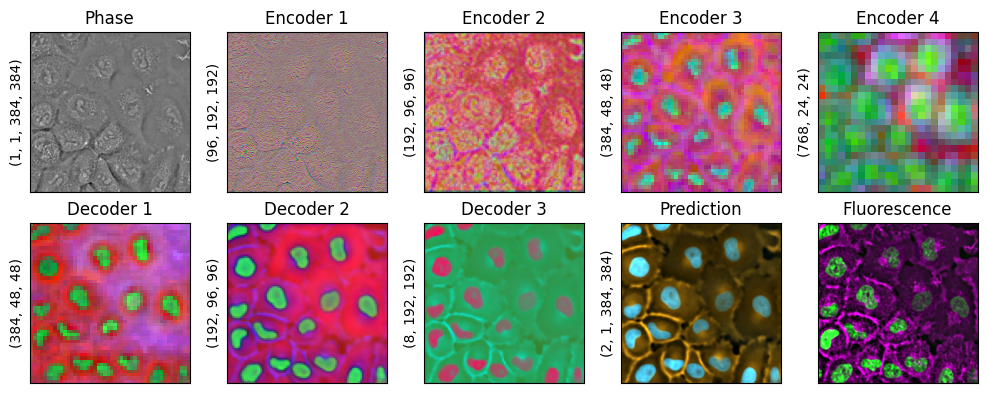

In [87]:
# Extract features
with torch.inference_mode():
    # encoder
    encoder_features = model.model.encoder(
        torch.from_numpy(phase_img.astype(np.float32)).to(model.device)
    )[0]
    encoder_features_np = [f.detach().cpu().numpy() for f in encoder_features]

    # Print the encoder features shapes
    for f in encoder_features_np:
        print(f.shape)

    # decoder
    features = encoder_features.copy()
    features.reverse()
    feat = features[0]
    features.append(None)
    decoder_features_np = []
    for skip, stage in zip(features[1:], model.model.decoder.decoder_stages):
        feat = stage(feat, skip)
        decoder_features_np.append(feat.detach().cpu().numpy())
    for f in decoder_features_np:
        print(f.shape)
    prediction = model.model.head(feat).detach().cpu().numpy()


# Defining the colors for plotting
class Color(NamedTuple):
    r: float
    g: float
    b: float


# Defining the colors for plottting the PCA
BOP_ORANGE = Color(0.972549, 0.6784314, 0.1254902)
BOP_BLUE = Color(BOP_ORANGE.b, BOP_ORANGE.g, BOP_ORANGE.r)
GREEN = Color(0.0, 1.0, 0.0)
MAGENTA = Color(1.0, 0.0, 1.0)


# Defining the functions to rescale the image and composite the nuclear and membrane images
def rescale_clip(image: torch.Tensor) -> np.ndarray:
    return rescale_intensity(image, out_range=(0, 1))[..., None].repeat(3, axis=-1)


def composite_nuc_mem(
    image: torch.Tensor, nuc_color: Color, mem_color: Color
) -> np.ndarray:
    c_nuc = rescale_clip(image[0]) * nuc_color
    c_mem = rescale_clip(image[1]) * mem_color
    return rescale_intensity(c_nuc + c_mem, out_range=(0, 1))


def clip_p(image: np.ndarray) -> np.ndarray:
    return rescale_intensity(image.clip(*np.percentile(image, [1, 99])))


def clip_highlight(image: np.ndarray) -> np.ndarray:
    return rescale_intensity(image.clip(0, np.percentile(image, 99.5)))


# Plot the PCA to RGB of the feature maps
f, ax = plt.subplots(2, 5, figsize=(10, 4))
n_components = 4
ax[0,0].imshow(phase_img[0, 0, 0], cmap="gray")
ax[0,0].set_ylabel(phase_img.shape[1:])
ax[0,0].set_title("Phase")

ax[1,-1].imshow(clip_p(composite_nuc_mem(fluo, GREEN, MAGENTA)))
ax[1,-1].set_title("Fluorescence")

for level, feat in enumerate(encoder_features_np):
    ax[0,level + 1].imshow(pcs_to_rgb(feat, n_components=n_components))
    ax[0,level + 1].set_title(f"Encoder {level + 1}")
    ax[0, level+1].set_ylabel(feat.shape[1:])

for level, feat in enumerate(decoder_features_np):
    ax[1, level].imshow(pcs_to_rgb(feat, n_components=n_components))
    ax[1, level].set_ylabel(feat.shape[1:])
    ax[1, level].set_title(f"Decoder {level + 1}")

pred_comp = composite_nuc_mem(prediction[0, :, 0], BOP_BLUE, BOP_ORANGE)
ax[1,-2].imshow(clip_p(pred_comp))
ax[1,-2].set_ylabel(prediction.shape[1:])
ax[1,-2].set_title(f"Prediction")

for a in ax.ravel():
    #a.axis("off")
    a.set(yticklabels=[],yticks=[], xticks=[], xticklabels=[])  

plt.tight_layout()

<div class="alert alert-info">

### Task 3.2: Select a sample batch to test the range of validty of the model
- Run the next cell to setup the your dataloader for `test` <br>
- Select a test batch from the `test_dataloader` by changing the `batch_number` <br>
- Examine the plot of the source and target images of the batch <br>

<b> Note the 2D images have different focus </b> <br>
</div>

In [41]:
YX_PATCH_SIZE = (256 * 2, 256 * 2)
source_channel = ["Phase3D"]
target_channel = ["Nucl", "Mem"]

normalizations = [
    NormalizeSampled(
        keys=source_channel,
        level="fov_statistics",
        subtrahend="mean",
        divisor="std",
    ),
    NormalizeSampled(
        keys=target_channel,
        level="fov_statistics",
        subtrahend="median",
        divisor="iqr",
    ),
]

# Re-load the dataloader
phase2fluor_2D_data = HCSDataModule(
    data_path,
    architecture="UNeXt2_2D",
    source_channel=source_channel,
    target_channel=target_channel,
    z_window_size=1,
    split_ratio=0.8,
    batch_size=1,
    num_workers=8,
    yx_patch_size=YX_PATCH_SIZE,
    augmentations=[],
    normalizations=normalizations,
)
phase2fluor_2D_data.setup("test")

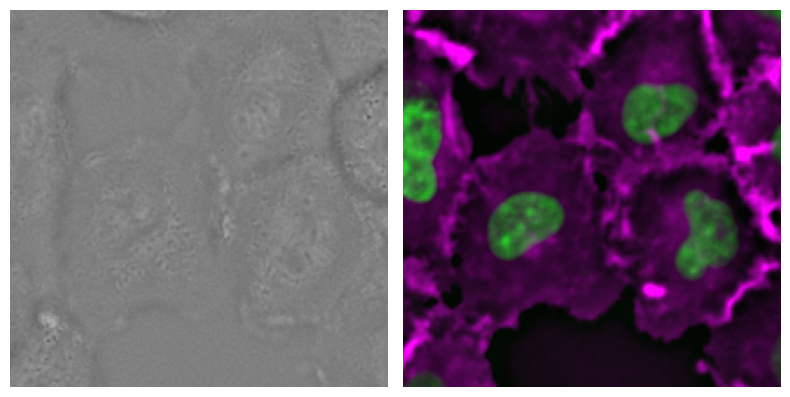

In [43]:
# ########## DONE ##############
batch_number = 1  # Change this to see different batches of data
# #######################
y_slice = slice(Y // 2 - 256 * n // 2, Y // 2 + 256 * n // 2)
x_slice = slice(X // 2 - 256 * n // 2, X // 2 + 256 * n // 2)

# Iterate through the test dataloader to get the desired batch
i = 0
for batch in phase2fluor_2D_data.test_dataloader():
    # break if we reach the desired batch
    if i == batch_number - 1:
        break
    i += 1

# Plot the batch source and target images
f, ax = plt.subplots(1, 2, figsize=(8, 12))
target_composite = composite_nuc_mem(batch["target"][0].cpu().numpy(), GREEN, MAGENTA)
ax[0].imshow(
    batch["source"][0, 0, 0, y_slice, x_slice].cpu().numpy(),
    cmap="gray",
    vmin=-15,
    vmax=15,
)
ax[1].imshow(clip_highlight(target_composite[0, y_slice, x_slice]))
for a in ax.ravel():
    a.axis("off")
f.tight_layout()
plt.show()

<div class="alert alert-info">

### Task 3.3: Using the selected batch to test the model's range of validity

- Given the selected batch use `monai.networks.layers.GaussianFilter` to blur the images with different sigmas.
 Check the documentation <a href="https://docs.monai.io/en/stable/networks.html#gaussianfilter">here</a> <br>
- Plot the source and predicted images comparing the source, target and added perturbations <br>
- How is the model's predictions given the perturbations? <br>
</div>

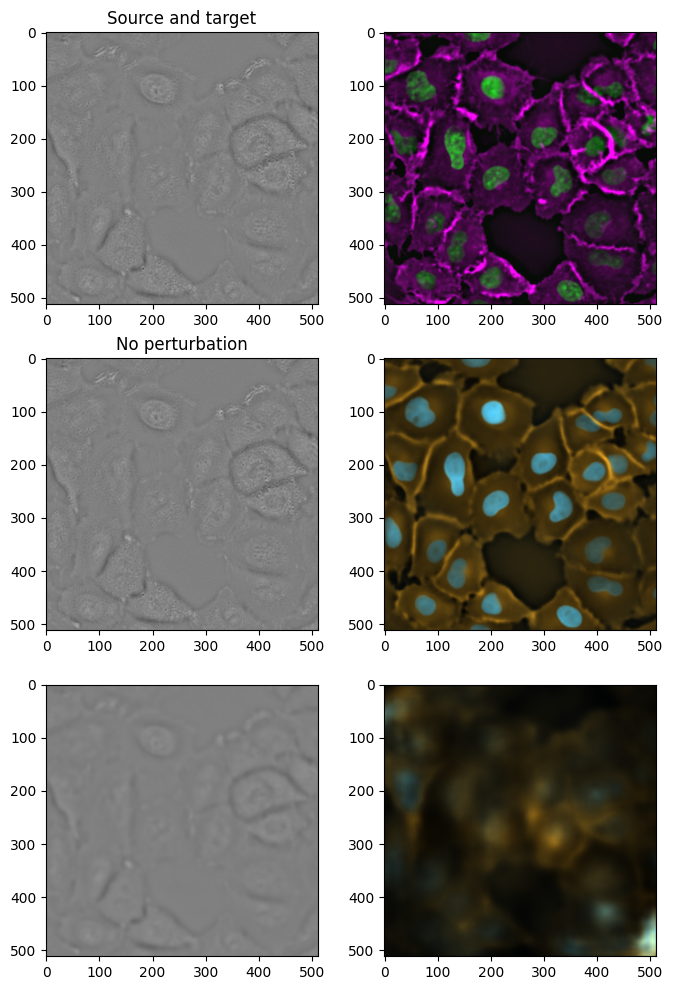

In [55]:
# ########## DONE ##############
# Try out different multiples of 256 to visualize larger/smaller crops
n = 2
# ##############################
# Center cropping the image
y_slice = slice(Y // 2 - 256 * n // 2, Y // 2 + 256 * n // 2)
x_slice = slice(X // 2 - 256 * n // 2, X // 2 + 256 * n // 2)

f, ax = plt.subplots(3, 2, figsize=(8, 12))

target_composite = composite_nuc_mem(batch["target"][0].cpu().numpy(), GREEN, MAGENTA)
ax[0, 0].imshow(
    batch["source"][0, 0, 0, y_slice, x_slice].cpu().numpy(),
    cmap="gray",
    vmin=-15,
    vmax=15,
)
ax[0, 1].imshow(clip_highlight(target_composite[0, y_slice, x_slice]))
ax[0, 0].set_title("Source and target")

# no perturbation
with torch.inference_mode():
    phase = batch["source"].to(model.device)[:, :, :, y_slice, x_slice]
    pred = model(phase).cpu().numpy()
pred_composite = composite_nuc_mem(pred[0], BOP_BLUE, BOP_ORANGE)
ax[1, 0].imshow(phase[0, 0, 0].cpu().numpy(), cmap="gray", vmin=-15, vmax=15)
ax[1, 1].imshow(pred_composite[0])
ax[1, 0].set_title("No perturbation")

# Select a sigma for the Gaussian filtering
# ########## DONE ##############
# Tensor dimensions (B,C,D,H,W).
# Hint: Use the GaussianFilter layer to blur the phase image. Provide the num spatial dimensions and sigmas
# Hint: Spatial (D,H,W)
gaussian_blur = GaussianFilter(spatial_dims=3, sigma=(0, 3, 3))
# #############################
with torch.inference_mode():
    phase = batch["source"].to(model.device)[:, :, :, y_slice, x_slice]
    phase = gaussian_blur(phase)
    pred = model(phase).cpu().numpy()
pred_composite = composite_nuc_mem(pred[0], BOP_BLUE, BOP_ORANGE)
ax[2, 0].imshow(phase[0, 0, 0].cpu().numpy(), cmap="gray", vmin=-15, vmax=15)
ax[2, 1].imshow(pred_composite[0])

<div class="alert alert-info">

### Task 3.3: Using the selected batch to test the model's range of validity

- Scale the pixel values up/down of the phase image <br>
- Plot the source and predicted images comparing the source, target and added perturbations <br>
- How is the model's predictions given the perturbations? <br>
</div>

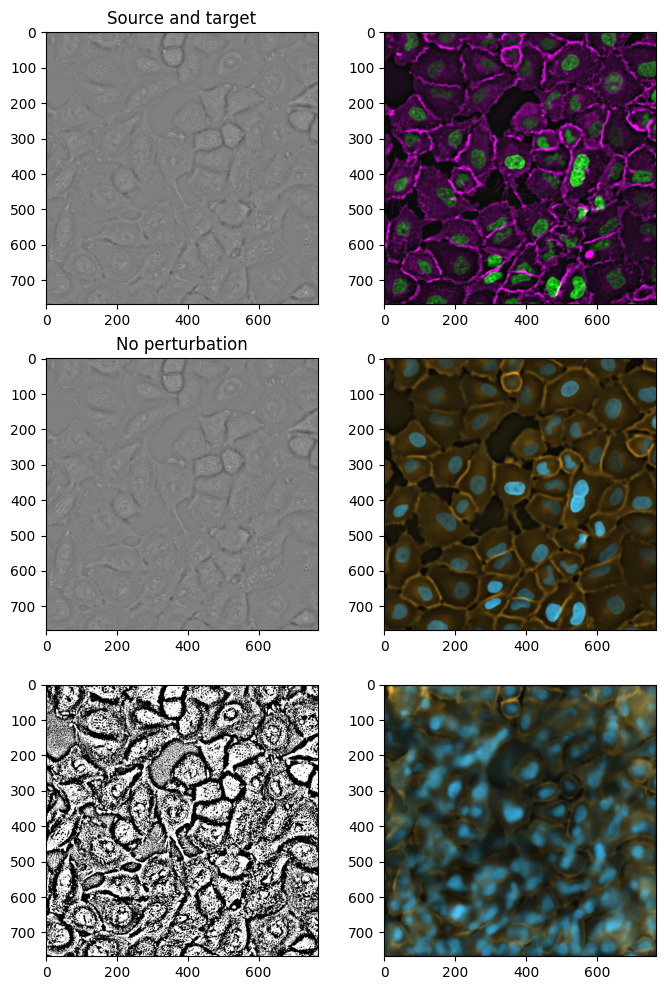

In [58]:
n = 3
y_slice = slice(Y // 2, Y // 2 + 256 * n)
x_slice = slice(X // 2, X // 2 + 256 * n)
f, ax = plt.subplots(3, 2, figsize=(8, 12))

target_composite = composite_nuc_mem(batch["target"][0].cpu().numpy(), GREEN, MAGENTA)
ax[0, 0].imshow(
    batch["source"][0, 0, 0, y_slice, x_slice].cpu().numpy(),
    cmap="gray",
    vmin=-15,
    vmax=15,
)
ax[0, 1].imshow(clip_highlight(target_composite[0, y_slice, x_slice]))
ax[0, 0].set_title("Source and target")

# no perturbation
with torch.inference_mode():
    phase = batch["source"].to(model.device)[:, :, :, y_slice, x_slice]
    pred = model(phase).cpu().numpy()
pred_composite = composite_nuc_mem(pred[0], BOP_BLUE, BOP_ORANGE)
ax[1, 0].imshow(phase[0, 0, 0].cpu().numpy(), cmap="gray", vmin=-15, vmax=15)
ax[1, 1].imshow(pred_composite[0])
ax[1, 0].set_title("No perturbation")


# Rescale the pixel value up/down
with torch.inference_mode():
    phase = batch["source"].to(model.device)[:, :, :, y_slice, x_slice]
    # ########## TODO ##############
    # Hint: Scale the phase intensity up/down until the model breaks
    phase = phase * 100 # TODO play here
    # #######################
    pred = model(phase).cpu().numpy()
pred_composite = composite_nuc_mem(pred[0], BOP_BLUE, BOP_ORANGE)
ax[2, 0].imshow(phase[0, 0, 0].cpu().numpy(), cmap="gray", vmin=-15, vmax=15)
ax[2, 1].imshow(pred_composite[0])

<div class="alert alert-warning">
<h3> Questions </h3>
How is the model's predictions given the blurring and scaling perturbations? <br> 
    Overshooting gaussian blur and scaling heavily degrades performance.
</div>

<div class="alert alert-success">

<h2>
🎉 The end of the notebook 🎉
</h2>

Congratulations! You have trained an image translation model, evaluated its performance, and explored what the network has learned.

</div>